# Определение возраста покупателей

## Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**План работы:**

1. Проведем исследовательский анализ набора фотографий
2. Обучим модель для определения возраста покупателей магазина
3. Проанализируем результат обучения модели

## Исследовательский анализ данных

Импортируем библиотеки, с которыми будем работать

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

Сохраняем данные в переменную `labels`

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


В датасете 7 591 строка и два столбца - название файла, возраст. С помощью загрузчика извлекаем изображения

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 


Found 7591 validated image filenames.


Всего нашли 7 591 фотографию. Подготовим признаки:

In [4]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 пикселя с тремя цветовыми каналами. Посмотрим на распределение данных по возрасту, для этого построим гистограмму:

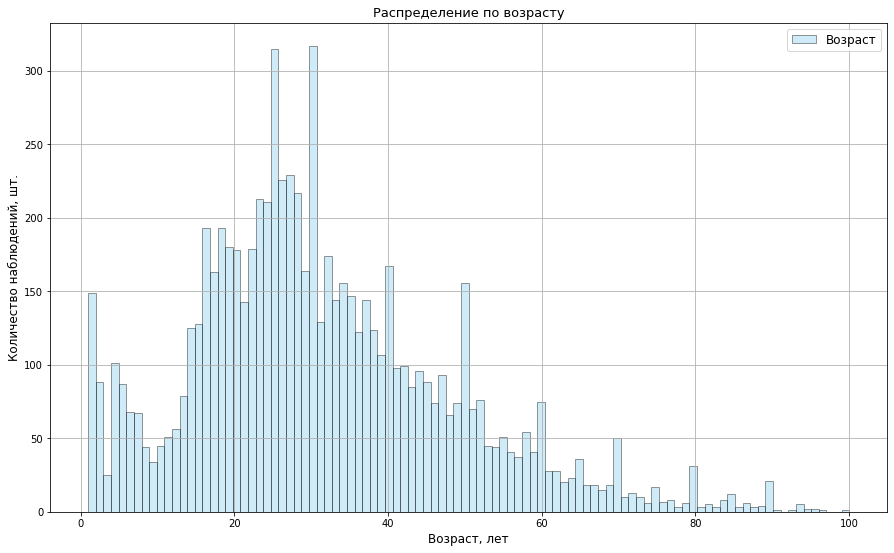

In [5]:
labels.plot(kind='hist', alpha=.4, figsize=(15, 9), grid=True, bins=100, color="skyblue", edgecolor="black")
plt.title('Распределение по возрасту', fontsize=13, y=1)
plt.xlabel('Возраст, лет', fontsize=12)
plt.ylabel('Количество наблюдений, шт.', fontsize=12)
plt.legend(['Возраст'], loc = 1, fontsize = 12)
plt.show()

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


На графике видно, что распределение близко к нормальному. Данные распределены в диапазоне от 1 до 100 лет, средний возраст - 31 год. Также видны выбивающиеся значения по "круглым датам" - 25, 30, 40, 50 лет. Вероятно разницу между 29 и 30 годами сложнее определить, поэтому больше данных округленные. Посмотрим на несколько фотографий:

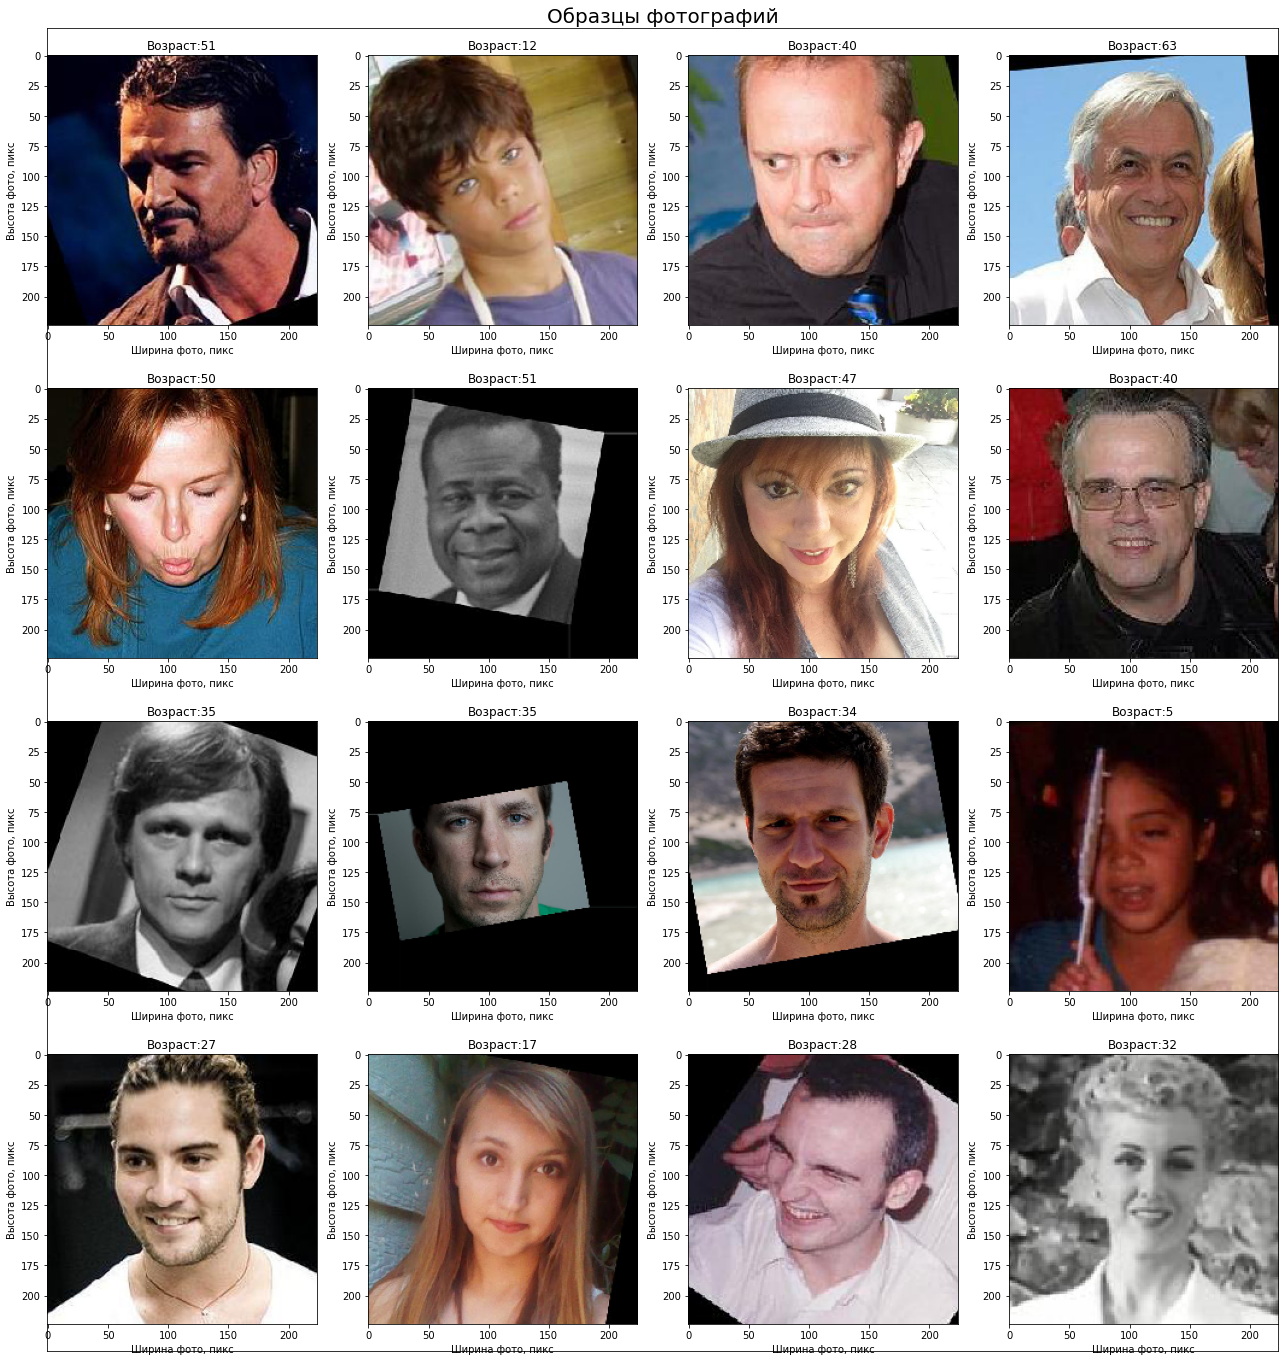

In [7]:
features, target = next(train_gen_flow)
fig = plt.figure(figsize=(18, 19))
plt.title('Образцы фотографий', fontsize = 20)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title('Возраст:' + str(target[i]))
    plt.xlabel('Ширина фото, пикс')
    plt.ylabel('Высота фото, пикс')
    plt.tight_layout()

Мы видим, что есть черно-белые изображения, есть фото людей в очках, с неудачного ракурса, все это может повлиять на качество модели. 

### Вывод 

Данных в обучающей выборке довольно мало, есть риск, что модель переобучится. Чтобы избежать такой проблемы, будем использовать аугментацию данных - увеличим количество изображений путем преобразования исходных изображений (горизонтальное отражение). Чтобы не искажать значения метрик, применим аугментацию только на обучающей выборке. Остальные данные оставим без изменений.

Общая ориентация фотографий правильная, но присутствуют фото, повернутые на несколько градусов. Размер изображений мы приводили к единому 224 * 224 и видно, что исходные фото разных размеров.

## Обучение модели

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```    

Результат вывода на экран:

```
Train for 356 steps, validate for 119 steps  
Epoch 1/10  
2022-06-30 08:17:06.845897: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2022-06-30 08:17:07.146630: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
356/356 - 48s - loss: 194.1177 - mae: 10.2067 - val_loss: 604.3140 - val_mae: 19.4383  
Epoch 2/10  
356/356 - 38s - loss: 82.8518 - mae: 6.9441 - val_loss: 130.3219 - val_mae: 8.6062  
Epoch 3/10  
356/356 - 38s - loss: 58.4108 - mae: 5.7939 - val_loss: 80.2332 - val_mae: 6.8169  
Epoch 4/10  
356/356 - 38s - loss: 43.0813 - mae: 5.0430 - val_loss: 135.4112 - val_mae: 9.1471  
Epoch 5/10  
356/356 - 38s - loss: 31.3715 - mae: 4.3089 - val_loss: 70.2832 - val_mae: 6.3400  
Epoch 6/10  
356/356 - 38s - loss: 23.8859 - mae: 3.7527 - val_loss: 64.4618 - val_mae: 6.0204  
Epoch 7/10  
356/356 - 38s - loss: 20.3215 - mae: 3.4464 - val_loss: 71.8580 - val_mae: 6.3053  
Epoch 8/10  
356/356 - 39s - loss: 17.1038 - mae: 3.1575 - val_loss: 71.2885 - val_mae: 6.2257  
Epoch 9/10  
356/356 - 38s - loss: 16.1335 - mae: 3.0185 - val_loss: 62.0209 - val_mae: 5.8983  
Epoch 10/10  
356/356 - 38s - loss: 14.0685 - mae: 2.8783 - val_loss: 76.3810 - val_mae: 6.7518  
WARNING:tensorflow:sample_weight modes were coerced from  
...  
to    
['...']  
119/119 - 9s - loss: 76.3810 - mae: 6.7518  
Test MAE: 6.7518
```

Поставленную задачу выполнили, обучили модель, получили качество модели (MAE = 6.75), удовлетворяющее условию задачи.

## Анализ обученной модели

Мы построили и обучили свёрточную нейронную сеть на датасете с фотографиями людей: 
* за основу взяли архитектуру ResNet50;
* обучили на 10 эпохах;
* использовали алгоритм оптимизации Adam со скоростью обучения learning rate = 0,0001;  
* выходной слой состоит из одного нейрона с функцией активации 'relu'.

Получили результат на обучающей выборке MAE = 2.88, на тестовой - 6,75. То есть наша модель ошибается примерно на 6,75 лет. 

Для цели "анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы" возможно следует использовать модель для категоризации и выделить несколько групп. Сложно найти отличия в предпочтении товаров у людей 33 и 34 лет. А вот для второй цели "контролировать добросовестность кассиров при продаже алкоголя" наша модель подходит и ее можно использовать в супермаркете "Хлеб-Соль".